Enter starting year: 2020
Enter starting month: 1
Enter starting day: 1
Enter a market: s&p
Enter a stock ticker symbol: googl
[*********************100%***********************]  1 of 1 completed
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2019-12-31  1335.790039  1340.660034  1332.130005  1339.390015  1339.390015   
2020-01-02  1348.410034  1368.680054  1346.489990  1368.680054  1368.680054   
2020-01-03  1348.000000  1373.750000  1347.319946  1361.520020  1361.520020   
2020-01-06  1351.630005  1398.319946  1351.000000  1397.810059  1397.810059   
2020-01-07  1400.459961  1403.500000  1391.560059  1395.109985  1395.109985   
...                 ...          ...          ...          ...          ...   
2021-06-16  2431.439941  2437.719971  2389.399902  2415.449951  2415.449951   
2021-06-17  2413.949951  2450.449951  2410.000000  2434.870117  2434.870117   
2021-06-18  24

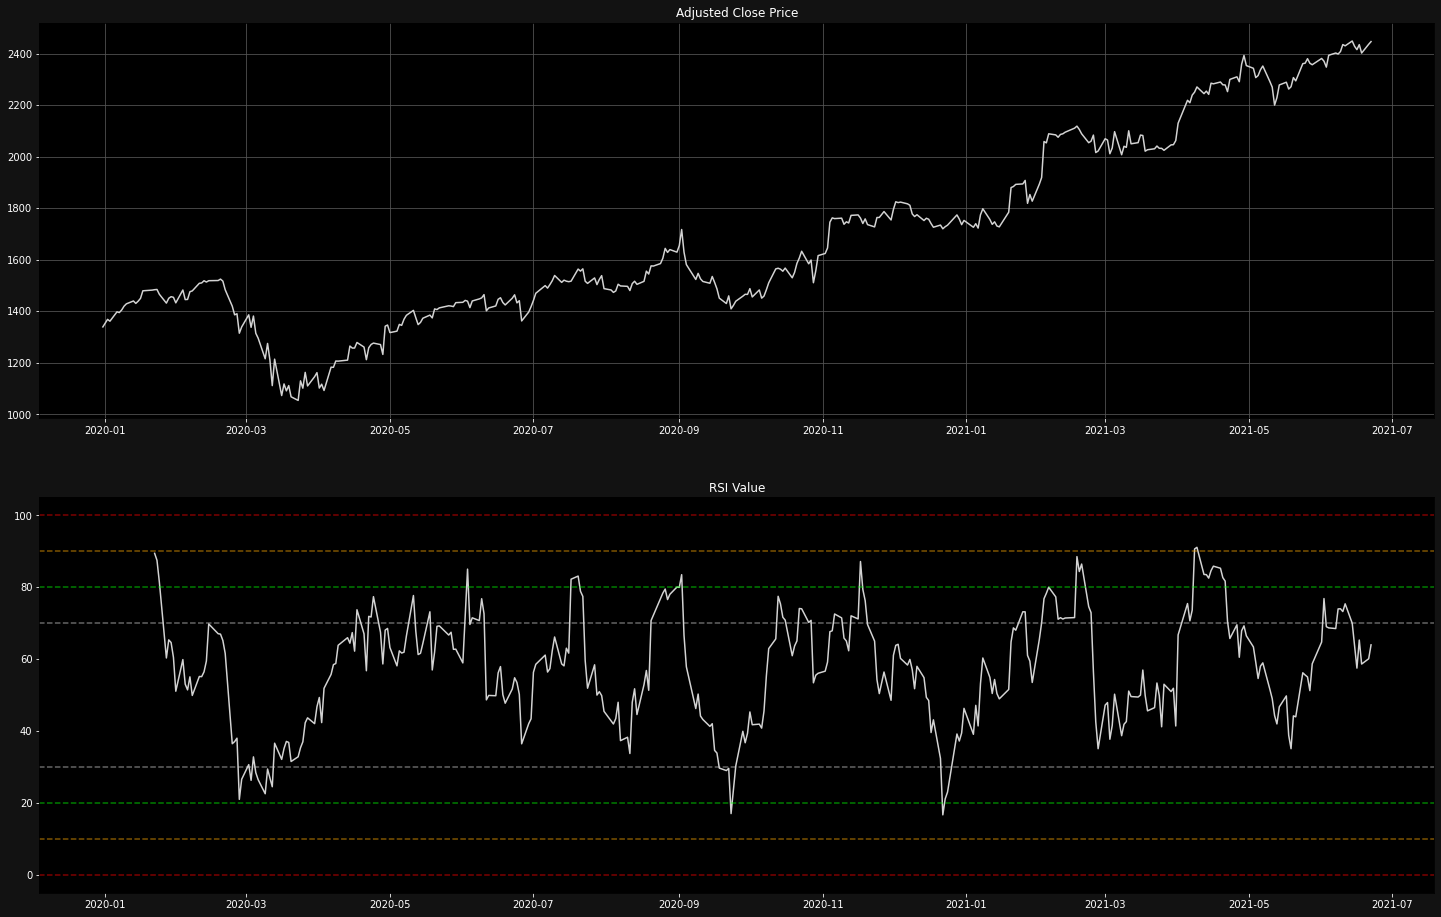

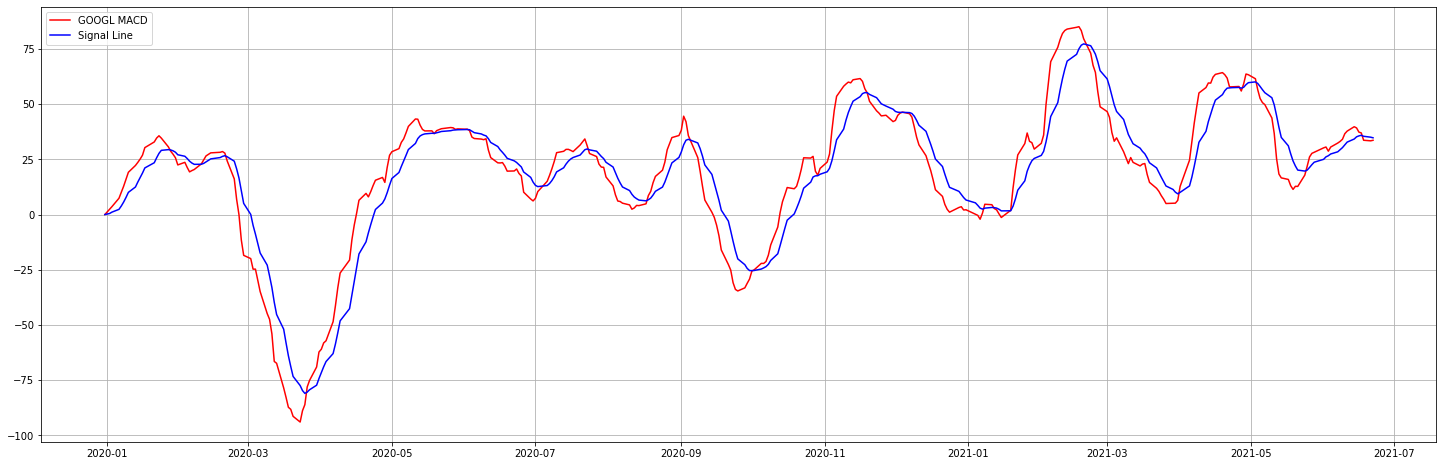

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

pd.set_option('display.max_rows', 50)

rsiPeriod = 14
maPeriods = [5, 9, 20, 50, 200]

yf.pdr_override()

# startyear = 2011
# startmonth = 1
# startday = 2

startyear = int(input("Enter starting year: "))
startmonth = int(input("Enter starting month: "))
startday = int(input("Enter starting day: "))

start = dt.datetime(startyear, startmonth, startday)
now=dt.datetime.now()

class Error(Exception):
    pass

class InvalidMarket(Error):
    pass

while True:
    try:
        market = input("Enter a market: ")
        market = market.upper()
        if market == "S&P" or market == "NASDAQ" or market == "SENSEX" or market == "HANG SENG" or market == "NIKKEI" or market == "FTSE":
            stock = input("Enter a stock ticker symbol: ")
            stock = stock.upper()
        else:
            raise InvalidMarket
        break
    except InvalidMarket:
        print("Market not registered in database. Please enter a registered market.")
        
if market == "S&P":
    df = pd.read_csv('S&P.csv')

if market == "NASDAQ":
    df = pd.read_csv("NASDAQ.csv")
    
if market == "FTSE":
    df = pd.read_csv("FTSE.csv")
    
if market == "SENSEX":
    df = pd.read_csv("SENSEX.csv")

if market == "NIKKEI":
    df = pd.read_csv("NIKKEI.csv")

if market == "HANG SENG":
    df = pd.read_csv("HANGSENG.csv")
    
for x in df['Ticker']:
    if stock == x.upper():
        df_stock = pdr.get_data_yahoo(stock, start, now)
            
        ## for moving averages
            
        for x in maPeriods:
            ma = x
            df_stock['MA_' + str(ma)] = round(df_stock.iloc[:, 4].rolling(window = ma).mean(), 2)

        ## for Moving Average Convergence Divergence (MACD) and Signal Line

        ## short term EMA

        ShortEMA = round(df_stock.iloc[:, 4].ewm(span = 12, adjust = False).mean(), 2)

        ## long term EMA

        LongEMA = round(df_stock.iloc[:, 4].ewm(span = 26, adjust = False).mean(), 2) 

        ## MACD line

        MACD = ShortEMA - LongEMA

        ## Signal line

        signal= round(MACD.ewm(span = 9, adjust = False).mean(), 2)

        df_stock['MACD'] = MACD
        df_stock['Signal Line'] = signal

        ## for RSI 

        delta = df_stock['Adj Close'].diff(1)
        delta.dropna(inplace = True) ## to drop rows which contain missing values

        positive = delta.copy()
        negative = delta.copy()

        positive[positive < 0] = 0
        negative[negative > 0] = 0

        avgGain = positive.rolling(window = rsiPeriod).mean()
        avgLoss = abs(negative.rolling(window = rsiPeriod).mean()) ## absolute value because we do not want a negative number

        relative_strength = avgGain / avgLoss
        RSI = 100.0 - (100.0 / (1.0 + relative_strength))

        df_stock['RSI_14'] = RSI

        print(df_stock)

        combined = pd.DataFrame() ## new column with Adj Close and RSI combined
        combined['Adj Close'] = df_stock['Adj Close']
        combined['RSI'] = RSI

        plt.figure(figsize = (25,16))

        ## plotting Adjusted Close

        ax1 = plt.subplot(211) ## number of rows is 2, number of column is 1, and plot number is 1    
        ax1.plot(combined.index, combined['Adj Close'], color = 'lightgray') ## looks through every element in the Adj Close column
        ax1.set_title("Adjusted Close Price", color = 'white')

        ax1.grid(True, color = '#555555') ## for displaying grid lines
        ax1.set_axisbelow(True)
        ax1.set_facecolor('black')
        ax1.figure.set_facecolor('#121212')
        ax1.tick_params(axis = 'x', colors = 'white')
        ax1.tick_params(axis = 'y', colors = 'white')

        ## plotting RSI

        ax2 = plt.subplot(212, sharex = ax1)
        ax2.plot(combined.index, combined['RSI'], color = 'lightgray')
        ax2.axhline(0, linestyle = '--', alpha = 0.5, color = '#ff0000')
        ax2.axhline(10, linestyle = '--', alpha = 0.5, color = '#ffaa00')
        ax2.axhline(20, linestyle = '--', alpha = 0.5, color = '#00ff00')
        ax2.axhline(30, linestyle = '--', alpha = 0.5, color = '#cccccc')
        ax2.axhline(70, linestyle = '--', alpha = 0.5, color = '#cccccc')
        ax2.axhline(80, linestyle = '--', alpha = 0.5, color = '#00ff00')
        ax2.axhline(90, linestyle = '--', alpha = 0.5, color = '#ffaa00')
        ax2.axhline(100, linestyle = '--', alpha = 0.5, color = '#ff0000')

        ax2.set_title("RSI Value", color = 'white')
        ax2.grid(False) ## for displaying grid lines
        ax2.set_axisbelow(True)
        ax2.set_facecolor('black')
        ax2.tick_params(axis = 'x', colors = 'white')
        ax2.tick_params(axis = 'y', colors = 'white')

        plt.show()

        ## plotting MACD and Signal line chart

        plt.figure(figsize = (25, 8))
        plt.plot(df_stock.index, MACD, label = stock + " MACD", color = 'red')
        plt.plot(df_stock.index, signal, label = "Signal Line", color = 'blue')
        plt.legend(loc = 'upper left')
        plt.grid(True)

        plt.show()

            



